In [1]:
import os
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Flatten, GRU, LSTM, Embedding, Bidirectional
from keras.optimizers import RMSprop
from keras.datasets import imdb
from keras.preprocessing import sequence
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Kaggle

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AGHyZR78FiP54awnS4bZQIwcpNqLhmO6agI6TZ2CBjjViB2xi4Zjmc
Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
!kaggle datasets download -d stytch16/jena-climate-2009-2016
!unzip \*.zip  && rm *.zip

In [2]:
fname = 'jena_climate_2009_2016.csv'
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [3]:
#ignore date time
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i,:] = values

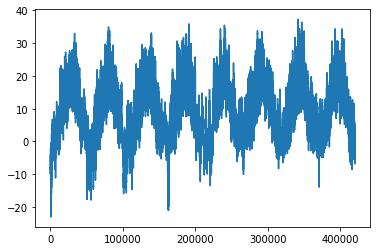

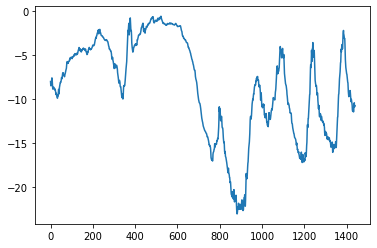

In [4]:
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()
plt.plot(range(1440), temp[:1440])
plt.show()

In [6]:
# normalize data
mean = float_data[:100000].mean(axis=0)
float_data -= mean
std = float_data[:100000].std(axis=0)
float_data /= std

In [7]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i+batch_size, max_index))
      i += len(rows)
    samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [9]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback,
                      delay,
                      0,
                      100000,
                      True,
                      batch_size,
                      step)

val_gen = generator(float_data,
                    lookback,
                    delay,
                    100001,
                    200000,
                    False,
                    batch_size,
                    step)

test_gen = generator(float_data,
                     lookback,
                     delay,
                     200001,
                     None,
                     False,
                     batch_size,
                     step)
# num iters over gen
val_steps = (200000 - 100001 - lookback) // batch_size
test_steps = (len(float_data) - 200001 - lookback) // batch_size

In [10]:
def evaluate_naive_method():
  # hypothesis: temp 24 hrs from now is same as the current temp
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:,-1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))
evaluate_naive_method()

0.33797206535378393


In [12]:
model = Sequential()
model.add(Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=(100000-lookback)//batch_size,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
770/770 [==============================] - 14s 18ms/step - loss: 0.5869 - val_loss: 0.3430
Epoch 2/20
770/770 [==============================] - 14s 19ms/step - loss: 0.2408 - val_loss: 0.3441
Epoch 3/20
770/770 [==============================] - 14s 18ms/step - loss: 0.2081 - val_loss: 0.3869
Epoch 4/20
770/770 [==============================] - 14s 18ms/step - loss: 0.1917 - val_loss: 0.3692
Epoch 5/20
770/770 [==============================] - 14s 18ms/step - loss: 0.1813 - val_loss: 0.3713
Epoch 6/20
770/770 [==============================] - 14s 18ms/step - loss: 0.1737 - val_loss: 0.4085
Epoch 7/20
770/770 [==============================] - 14s 18ms/step - loss: 0.1683 - val_loss: 0.3867
Epoch 8/20
770/770 [==============================] - 14s 19ms/step - loss: 0.1641 - val_loss: 0.3777
Epoch 9/20
770/770 [==============================] - 14s 18ms/step - loss: 0.1591 - val_loss: 0.3971
Epoch 10/20
770/770 [==============================] - 14s 18ms/step - loss: 0.158

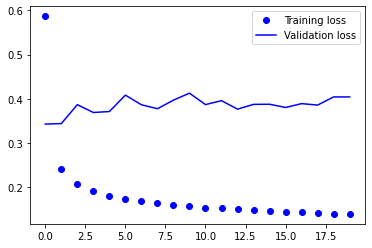

In [13]:
def plot_graph(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.legend()
  plt.show()
plot_graph(history)

In [14]:
model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2903 - val_loss: 0.3186
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2726 - val_loss: 0.3201
Epoch 3/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2598 - val_loss: 0.3235
Epoch 4/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2498 - val_loss: 0.3246
Epoch 5/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2423 - val_loss: 0.3341
Epoch 6/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2330 - val_loss: 0.3380
Epoch 7/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2259 - val_loss: 0.3380
Epoch 8/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2187 - val_loss: 0.3496
Epoch 9/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2079 - val_loss: 0.3485
Epoch 10/20
500/500 [==============================] - 15s 31ms/step - loss: 0.200

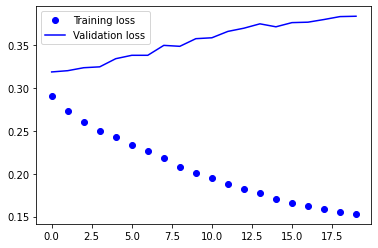

In [15]:
plot_graph(history)

In [16]:
#fight overfitting
model = Sequential()
model.add(GRU(32,
              dropout=0.2,
              recurrent_dropout=0.2,
              input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=100,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/40
100/100 [==============================] - 112s 1s/step - loss: 0.3671 - val_loss: 0.3398
Epoch 2/40
100/100 [==============================] - 112s 1s/step - loss: 0.3099 - val_loss: 0.3313
Epoch 3/40
100/100 [==============================] - 112s 1s/step - loss: 0.3042 - val_loss: 0.3306
Epoch 4/40
100/100 [==============================] - 114s 1s/step - loss: 0.3009 - val_loss: 0.3267
Epoch 5/40
100/100 [==============================] - 112s 1s/step - loss: 0.2949 - val_loss: 0.3268
Epoch 6/40
100/100 [==============================] - 112s 1s/step - loss: 0.2964 - val_loss: 0.3281
Epoch 7/40
100/100 [==============================] - 111s 1s/step - loss: 0.2898 - val_loss: 0.3285
Epoch 8/40
100/100 [==============================] - 112s 1s/step - loss: 0.2914 - val_loss: 0.3251
Epoch 9/40
100/100 [==============================] - 114s 1s/step - loss: 0.2847 - val_loss: 0.3253
Epoch 10/40
100/100 [==============================] - 111s 1s/step - loss: 0.2885 - val_lo

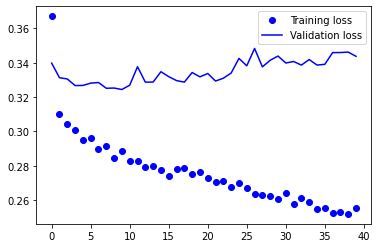

In [17]:
plot_graph(history)

In [18]:
model = Sequential()
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True,
              input_shape=(None, float_data.shape[-1])))
model.add(GRU(16, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=50,
                    epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
50/50 [==============================] - 161s 3s/step - loss: 0.4208 - val_loss: 0.3685
Epoch 2/20
50/50 [==============================] - 159s 3s/step - loss: 0.3279 - val_loss: 0.3532
Epoch 3/20
50/50 [==============================] - 157s 3s/step - loss: 0.3165 - val_loss: 0.3448
Epoch 4/20
50/50 [==============================] - 157s 3s/step - loss: 0.3020 - val_loss: 0.3418
Epoch 5/20
50/50 [==============================] - 159s 3s/step - loss: 0.3107 - val_loss: 0.3367
Epoch 6/20
50/50 [==============================] - 156s 3s/step - loss: 0.3004 - val_loss: 0.3334
Epoch 7/20
50/50 [==============================] - 156s 3s/step - loss: 0.3070 - val_loss: 0.3306
Epoch 8/20
50/50 [==============================] - 157s 3s/step - loss: 0.2998 - val_loss: 0.3334
Epoch 9/20
50/50 [==============================] - 154s 3s/step - loss: 0.2950 - val_loss: 0.3319
Epoch 10/20
50/50 [==============================] - 154s 3s/step - loss: 0.2956 - val_loss: 0.3338
Epoch 11/

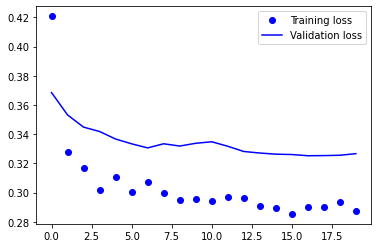

In [20]:
plot_graph(history)

In [25]:
def reverse_order_generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(min_index+lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples[:,::-1,:], targets

In [26]:
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size
)

val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size
)

In [27]:
model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 16s 33ms/step - loss: 0.4890 - val_loss: 0.4938
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.4657 - val_loss: 0.4692
Epoch 3/20
500/500 [==============================] - 16s 32ms/step - loss: 0.4028 - val_loss: 0.4237
Epoch 4/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3535 - val_loss: 0.4066
Epoch 5/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3263 - val_loss: 0.3814
Epoch 6/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3066 - val_loss: 0.3336
Epoch 7/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2905 - val_loss: 0.3304
Epoch 8/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2777 - val_loss: 0.3319
Epoch 9/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2731 - val_loss: 0.3284
Epoch 10/20
500/500 [==============================] - 16s 32ms/step - loss: 0.266

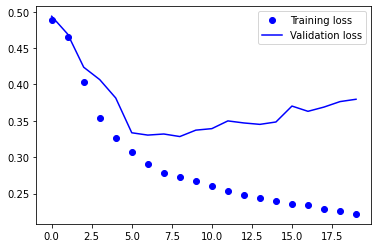

In [28]:
plot_graph(history)

In [29]:
# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

17465344/17464789 [==============================] - 0s 0us/step
Epoch 1/10
157/157 [==============================] - 8s 50ms/step - loss: 0.4919 - acc: 0.7711 - val_loss: 0.3427 - val_acc: 0.8666
Epoch 2/10
157/157 [==============================] - 7s 47ms/step - loss: 0.3120 - acc: 0.8785 - val_loss: 0.5254 - val_acc: 0.7900
Epoch 3/10
157/157 [==============================] - 7s 47ms/step - loss: 0.2539 - acc: 0.9075 - val_loss: 0.3199 - val_acc: 0.8710
Epoch 4/10
157/157 [==============================] - 7s 47ms/step - loss: 0.2143 - acc: 0.9226 - val_loss: 0.3049 - val_acc: 0.8856
Epoch 5/10
157/157 [==============================] - 7s 47ms/step - loss: 0.1861 - acc: 0.9324 - val_loss: 0.4456 - val_acc: 0.8544
Epoch 6/10
157/157 [==============================] - 7s 47ms/step - loss: 0.1671 - acc: 0.9419 - val_loss: 0.3556 - val_acc: 0.8772
Epoch 7/10
157/157 [==============================] - 7s 47ms/step - loss: 0.1495 - acc: 0.9480 - val_loss: 0.3760 - val_acc: 0.8556
Epoc

In [31]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 9s 55ms/step - loss: 0.5937 - acc: 0.6881 - val_loss: 0.4436 - val_acc: 0.8344
Epoch 2/10
157/157 [==============================] - 8s 49ms/step - loss: 0.3734 - acc: 0.8502 - val_loss: 0.3576 - val_acc: 0.8692
Epoch 3/10
157/157 [==============================] - 8s 48ms/step - loss: 0.2818 - acc: 0.8959 - val_loss: 0.4336 - val_acc: 0.8690
Epoch 4/10
157/157 [==============================] - 7s 48ms/step - loss: 0.2339 - acc: 0.9134 - val_loss: 0.3202 - val_acc: 0.8726
Epoch 5/10
157/157 [==============================] - 7s 47ms/step - loss: 0.2067 - acc: 0.9277 - val_loss: 0.3140 - val_acc: 0.8726
Epoch 6/10
157/157 [==============================] - 7s 47ms/step - loss: 0.1864 - acc: 0.9355 - val_loss: 0.3982 - val_acc: 0.8438
Epoch 7/10
157/157 [==============================] - 7s 47ms/step - loss: 0.1665 - acc: 0.9423 - val_loss: 0.3439 - val_acc: 0.8634
Epoch 8/10
157/157 [==============================] - 7s 47ms/step - 

In [33]:
model = Sequential()
model.add(Bidirectional(GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 22s 44ms/step - loss: 0.2755 - val_loss: 0.3248
Epoch 2/40
500/500 [==============================] - 22s 44ms/step - loss: 0.2580 - val_loss: 0.3144
Epoch 3/40
500/500 [==============================] - 22s 44ms/step - loss: 0.2438 - val_loss: 0.3306
Epoch 4/40
500/500 [==============================] - 22s 43ms/step - loss: 0.2337 - val_loss: 0.3257
Epoch 5/40
500/500 [==============================] - 22s 43ms/step - loss: 0.2255 - val_loss: 0.3301
Epoch 6/40
500/500 [==============================] - 22s 43ms/step - loss: 0.2147 - val_loss: 0.3449
Epoch 7/40
500/500 [==============================] - 22s 43ms/step - loss: 0.2041 - val_loss: 0.3502
Epoch 8/40
500/500 [==============================] - 22s 43ms/step - loss: 0.1940 - val_loss: 0.3580
Epoch 9/40
500/500 [==============================] - 22s 43ms/step - loss: 0.1860 - val_loss: 0.3677
Epoch 10/40
500/500 [==============================] - 22s 43ms/step - loss: 0.177

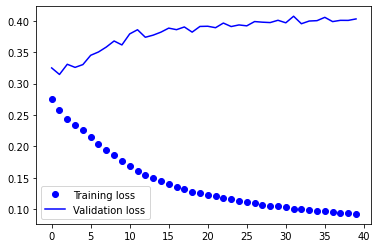

In [34]:
plot_graph(history)